In [1]:
import ee
from osgeo import gdal
from osgeo import osr
import pandas as pd
import numpy as np
import time
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

#from save_gee_image_tiff import save_gee_tiff
ee.Initialize()

C:\Users\vinim\anaconda3\envs\gdalenv\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


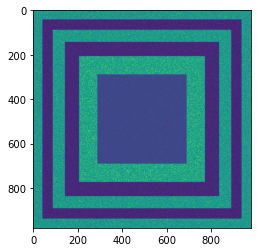

<AxesSubplot:>

In [2]:
validation = rasterio.open('../../../idl/Default/simulation2.tif')
show(validation.read(4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


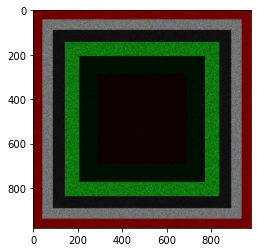

In [3]:
composite = np.dstack((validation.read(20), validation.read(19), validation.read(18)))
plt.imshow(composite)

In [4]:
import math
shp = validation.read(10).shape[1]/2
c = int(shp)
area = 400*400
#training_pixels = validation.read()[:,int(c-(np.sqrt(area)/2)):int(c+(np.sqrt(area)/2)),int(c-(np.sqrt(area)/2)):int(c+(np.sqrt(area)/2))]
training_pixels = validation.read()[:,400:600,400:600]
tp = training_pixels.reshape(-1,1)
len(tp)

4000000

In [5]:
beta = float(input('digite o valor de beta: '))
new_dataset = int(beta * len(tp))
dataind = np.random.choice(len(tp), size=new_dataset)
tp_opt = tp[dataind]
len(tp_opt)

digite o valor de beta: 0.0025


10000

### Otimização One-Class SVM

In [6]:
import math
shp = validation.read(10).shape[1]/2
c = int(shp)
area = 400*400
x = np.zeros(validation.read(10).shape)
for i in ([6,5,4,3,2,1]):
    x[int(c-(np.sqrt(i*area)/2)):int(c+(np.sqrt(i*area)/2)+1),int(c-(np.sqrt(i*area)/2)):int(c+(np.sqrt(i*area)/2)+1)] = i-1
    
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
base_df = pd.DataFrame(index=labels)
#base_df

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def metricas(x,tab_ex2):
    sm = tab_ex2.sum(axis=1).values.reshape(979,979)
    valida = np.where(sm<=0, int(1), sm)
    valida = np.where(((valida>0)&(valida<=20)), int(1), valida)
    valida = np.where(((valida>20)&(valida<=40)), int(2), valida)
    valida = np.where((valida>40)&(valida<=60), int(3), valida)
    valida = np.where(((valida>60)&(valida<=80)), int(4), valida)
    valida = np.where(((valida>80)&(valida<=100)), int(5), valida)
    valida_teste = valida.copy()
    valida_teste[int(c-(np.sqrt(area)/2)):int(c+(np.sqrt(area)/2)+1),int(c-(np.sqrt(area)/2)):int(c+(np.sqrt(area)/2)+1)] = 0
    valida_teste = valida_teste.reshape(-1,1)
    new_valida = np.delete(valida_teste, np.where(valida_teste==0))
    xx = x.reshape(-1,1)
    new_x = np.delete(xx, np.where(xx==0))
    valor = f1_score(new_x.reshape(-1,1),new_valida.reshape(-1,1), average=None)
    return valor

def isola(df, classificador):
    x = df.to_numpy().reshape(-1,1)
    res2 = classificador.predict(x)
    res = np.where(res2 < 0, abs(2*res2), 0)
    ser = pd.Series(res, index=df.index)
    return ser

def cria_dataf(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = isola(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

In [8]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

teste = validation.read().reshape([100,-1])[:50]
t = pd.DataFrame(teste.T)
comp_df_oc = base_df.copy()
t.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.136063,-0.645604,0.030371,0.391179,0.279691,0.444063,0.391621,-0.354475,0.251504,0.342807,...,0.238572,-0.566338,-0.309675,-0.492575,0.119648,0.576570,0.858316,-0.019600,-0.462980,-0.671923
1,-0.027469,-0.465488,0.003522,0.764328,0.387459,0.415183,0.664908,-0.429032,0.285279,0.371988,...,0.348536,-0.474457,-0.511611,-0.513670,0.088729,0.225399,0.447000,-0.019151,-0.232510,-0.496810
2,-0.110070,-0.526775,0.027370,0.436474,0.352142,0.498285,0.246589,-0.492852,0.301435,0.385654,...,0.319640,-0.417392,-0.606746,-0.367251,0.005383,0.707108,0.268633,-0.200000,-0.400476,-0.251627
3,-0.018945,-0.483885,0.092297,0.571872,0.322584,0.409332,0.396018,-0.266815,0.308174,0.668949,...,0.720401,-0.812706,-0.265237,-0.454806,0.099927,0.274903,0.351157,-0.092687,-0.255873,-0.733823
4,-0.095119,-0.368250,0.048000,0.313149,0.421068,0.230380,0.758748,-0.218757,0.279563,0.327872,...,0.528386,-0.514975,-0.616596,-0.232811,0.021928,0.438881,0.257301,-0.047601,-0.316573,-0.245039


In [9]:
#comp_df_oc = base_df.copy()
dict_atua = {'OCSVM_nu_0.025': [0.951038, 0.651241, 0.105222, 0.010581, 0.000103],
            'OCSVM_nu_0.05': [0.840595, 0.870718, 0.990308, 0.994402, 0.994279],
            'OCSVM_nu_0.1': [0.342966, 0.616279, 0.902855, 0.991923, 0.994247] }
chaves = list(dict_atua.keys())
for i in range(3):
    ser = pd.Series(dict_atua[chaves[i]], index=base_df.index)
    comp_df_oc.loc[:,chaves[i]] = ser
    
comp_df_oc

,OCSVM_nu_0.025,OCSVM_nu_0.05,OCSVM_nu_0.1
Very Low,0.951038,0.840595,0.342966
Low,0.651241,0.870718,0.616279
Medium,0.105222,0.990308,0.902855
High,0.010581,0.994402,0.991923
Very High,0.000103,0.994279,0.994247


#### Loop f1socre

In [10]:
#nuu = [0.001, 0.005, 0.01, 0.05, 0.1]
nuu = [0.25, 0.5] #[0.05,0.1,0.25,0.5] #[0.025]
data_dict = {}
for i in nuu:
    a = time.time()
    classificador = OneClassSVM(nu=i, kernel='rbf', gamma='auto').fit(tp_opt)
    b = time.time()
    print(str(b-a) + ' segundos')
    tab_ex = cria_dataf(t, classificador)
    d = time.time()
    nest = "OCSVM_nu_" + str(i)
    print(nest + " " + str((d-b)/60) + ' minutos')
    ser = pd.Series(metricas(x,tab_ex), index=base_df.index)
    comp_df_oc.loc[:,nest] = ser
    data_dict[i] = tab_ex
    display(comp_df_oc.head())

1.600954294204712 segundos
OCSVM_nu_0.25 257.10955459276835 minutos


,OCSVM_nu_0.025,OCSVM_nu_0.05,OCSVM_nu_0.1,OCSVM_nu_0.25
Very Low,0.951038,0.840595,0.342966,0.001153
Low,0.651241,0.870718,0.616279,0.067589
Medium,0.105222,0.990308,0.902855,0.436856
High,0.010581,0.994402,0.991923,0.806557
Very High,0.000103,0.994279,0.994247,0.975399


3.740839719772339 segundos
OCSVM_nu_0.5 1150.646993203958 minutos


,OCSVM_nu_0.025,OCSVM_nu_0.05,OCSVM_nu_0.1,OCSVM_nu_0.25,OCSVM_nu_0.5
Very Low,0.951038,0.840595,0.342966,0.001153,0.000000
Low,0.651241,0.870718,0.616279,0.067589,0.000012
Medium,0.105222,0.990308,0.902855,0.436856,0.008472
High,0.010581,0.994402,0.991923,0.806557,0.196156
Very High,0.000103,0.994279,0.994247,0.975399,0.718298


In [11]:
comp_df_oc

,OCSVM_nu_0.025,OCSVM_nu_0.05,OCSVM_nu_0.1,OCSVM_nu_0.25,OCSVM_nu_0.5
Very Low,0.951038,0.840595,0.342966,0.001153,0.000000
Low,0.651241,0.870718,0.616279,0.067589,0.000012
Medium,0.105222,0.990308,0.902855,0.436856,0.008472
High,0.010581,0.994402,0.991923,0.806557,0.196156
Very High,0.000103,0.994279,0.994247,0.975399,0.718298


<AxesSubplot:title={'center':'f1 score by Anomaly Probability'}, xlabel='Anomaly probability', ylabel='f1 score'>

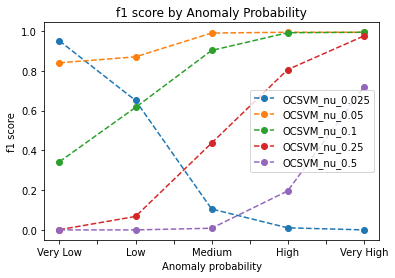

In [12]:
comp_df_oc.plot(title='f1 score by Anomaly Probability', xlabel='Anomaly probability', ylabel='f1 score',linestyle='--', marker='o')

In [13]:
comp_df_oc.to_csv('F1_Score_OCSVM_Data.csv')

#### Continuação

<AxesSubplot:title={'center':'f1 score by Anomaly Probability'}, xlabel='Anomaly probability', ylabel='f1 score'>

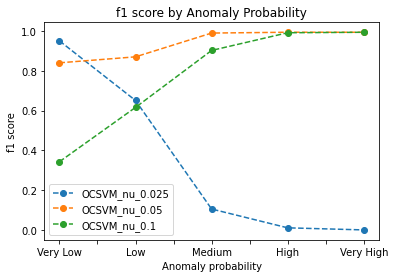

In [20]:
comp_df_oc_v2.plot(title='f1 score by Anomaly Probability', xlabel='Anomaly probability', ylabel='f1 score',linestyle='--', marker='o')

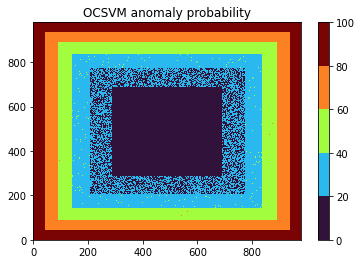

In [50]:
import matplotlib as mpl
sm = data_dict[0.05].sum(axis=1).values.reshape(979,979)

fig, ax = plt.subplots()

cmap = mpl.cm.turbo
bounds = [0, 20, 40, 60, 80, 100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )
pcm = ax.pcolormesh(sm, norm=norm, cmap=cmap)
fig.colorbar(pcm)
plt.title('OCSVM anomaly probability')
plt.show()

<AxesSubplot:title={'center':'f1 score by Anomaly Probability'}, xlabel='Anomaly probability', ylabel='f1 score'>

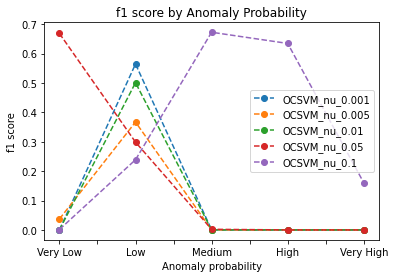

In [22]:
comp_df_oc.plot(title='f1 score by Anomaly Probability', xlabel='Anomaly probability', ylabel='f1 score',linestyle='--', marker='o')

In [ ]:
nuu = [0.001, 0.005, 0.01, 0.05, 0.1]
comp_df_oc2 = base_df.copy()
for i in nuu:
    classificador = OneClassSVM(nu=i).fit(tp_opt)
    print(i)
    tab_ex = cria_dataf(t, classificador)
    print(i)
    nest = "OCSVM_nu_" + str(i)
    ser = pd.Series(metricas(x,tab_ex), index=base_df.index)
    comp_df_oc2.loc[:,nest] = ser
    print('foi')
    
comp_df_oc2

0.001
0.001
foi
0.005
0.005
foi
0.01


In [30]:
comp_df_oc2

,OCSVM_nu_0.001,OCSVM_nu_0.005,OCSVM_nu_0.01
Very Low,0.388858,0.000554,0.000017
Low,0.085675,0.424340,0.369406
Medium,0.000000,0.000736,0.000534
High,0.000000,0.000000,0.000000
Very High,0.000000,0.000000,0.000000


### Otimização Isolation Forest

In [10]:
import math
shp = validation.read(10).shape[1]/2
c = int(shp)
area = 400*400
x = np.zeros(validation.read(10).shape)
for i in ([6,5,4,3,2,1]):
    x[int(c-(np.sqrt(i*area)/2)):int(c+(np.sqrt(i*area)/2)+1),int(c-(np.sqrt(i*area)/2)):int(c+(np.sqrt(i*area)/2)+1)] = i-1
    
x

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

In [11]:
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
base_df = pd.DataFrame(index=labels)
base_df

""
Very Low
Low
Medium
High
Very High


In [13]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

teste = validation.read().reshape([100,-1])
t = pd.DataFrame(teste.T)
inicio = 20
comp_df = base_df.copy()

for i in range(5):
    valor = inicio + i*20
    classificador = IsolationForest(n_estimators=valor,random_state=0,
                                n_jobs=-1,max_samples='auto').fit(tp)
    
    tab_ex = cria_dataf(t, classificador)
    print(i)
    nest = "IF_" + str(valor)
    ser = pd.Series(metricas(x,tab_ex), index=base_df.index)
    comp_df.loc[:,nest] = ser
    print('foi')
    
comp_df

0
foi
1
foi
2
foi
3
foi
4
foi


,IF_20,IF_40,IF_60,IF_80,IF_100
Very Low,0.780948,0.842710,0.827663,0.808059,0.760637
Low,0.840208,0.875170,0.866089,0.855100,0.830226
Medium,0.990786,0.993524,0.992855,0.992241,0.990243
High,0.994228,0.994334,0.994315,0.994275,0.994225
Very High,0.994279,0.994279,0.994279,0.994279,0.994279


In [16]:
ocsvm = [0.813267, 0.858453, 0.992979, 0.994383, 0.994279]
ser = pd.Series(ocsvm, index=base_df.index)
comp_df.loc[:, "One-Class SVM"] = ser

<AxesSubplot:title={'center':'f1 score by Anomaly Probability'}, xlabel='Anomaly probability', ylabel='f1 score'>

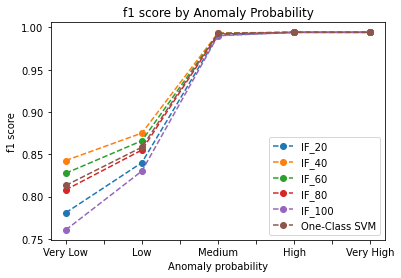

In [19]:
#oioi = base_copy['One-Class SVM'].values
#tchau = pd.Series(oioi, index=base_df.index)
#comp_df.loc[:,'One-Class SVM'] = tchau
comp_df.plot(title='f1 score by Anomaly Probability', xlabel='Anomaly probability', ylabel='f1 score',linestyle='--', marker='o')